In [ ]:
!wget https://raw.githubusercontent.com/mwbaj/MachineLearning/ZPS_2023_winter/WAWTPC/io_functions.py
!pip install uproot

--2023-11-25 15:18:55--  https://raw.githubusercontent.com/mwbaj/MachineLearning/ZPS_2023_winter/WAWTPC/io_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7638 (7.5K) [text/plain]
Saving to: ‘io_functions.py.3’

io_functions.py.3   100%[===================>]   7.46K  --.-KB/s    in 0s      

2023-11-25 15:18:55 (40.5 MB/s) - ‘io_functions.py.3’ saved [7638/7638]



In [ ]:
import numpy as np
from numba import jit
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
import tensorflow as tf
from tensorflow.python.ops.numpy_ops import np_config
import tensorflow_datasets as tfds
import io_functions as io
from tensorflow.data import Dataset, TFRecordDataset
from tensorflow.io import TFRecordWriter, TFRecordOptions
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Example, Features, Feature
from multiprocessing import Process, Queue
from os.path import isfile


np_config.enable_numpy_behavior()
drive.mount('/content/drive')
dataPath = 'drive/MyDrive/ZPS/simulated_data/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def serialize(charge_array, target):
  feature = {'myChargeArray' : _bytes_feature(tf.io.serialize_tensor(charge_array)),
             'target' : _bytes_feature(tf.io.serialize_tensor(target))}
  example = tf.train.Example(features=tf.train.Features(feature=feature))
  return example.SerializeToString()

def XYZtoUVWT(data):
    referencePoint = tf.constant([-138.9971, 98.25])
    phi = np.pi/6.0
    stripPitch = 1.5
    f = 1.0/25*6.46
    u = -(data[:, 1]-99.75)
    v = (data[:, 0]-referencePoint[0]) * np.cos(phi) - (data[:, 1]-referencePoint[1]) * np.sin(phi)
    w = (data[:, 0]-referencePoint[0]) * np.cos(-phi) - (data[:, 1]-referencePoint[1]) * np.sin(-phi) + 98.75
    t = data[:, 2]/f + 256
    u/=stripPitch
    v/=stripPitch
    w/=stripPitch
    return tf.stack([u,v,w,t], axis=0).T

def conversion(filename, queue):
    options = TFRecordOptions(compression_type='GZIP')
    writer = TFRecordWriter(filename, options=options)
    scale = 100
    n_projections = 3
    while True:
        item = queue.get()
        if item == None:
            break

        myChargeArray, target = item
        charge_array= io.proc_features(myChargeArray)

        uvwt_1 = XYZtoUVWT(scale*target[:, 0:3])
        uvwt_2 = XYZtoUVWT(scale*target[:, 3:6])
        uvwt_3 = XYZtoUVWT(scale*target[:, 6:9])

        for projection in range(n_projections):
          points = tf.stack([
              uvwt_1[:, 3], uvwt_1[:, projection],
              uvwt_2[:, 3], uvwt_2[:, projection],
              uvwt_3[:, 3], uvwt_3[:, projection]
              ]).T
          example = serialize(charge_array[:, :, :, projection], points)
          writer.write(example)

In [ ]:
def process_file(output_files, datasetGenerator):
  nFiles = len(output_files)
  for file in output_files:
      if isfile(file):
          raise Exception('output file already exists')

  if __name__ == '__main__':
      processes = []
      q = Queue(2*nFiles)

      for name in output_files:
          p = Process(target=conversion, args=(name, q))
          processes.append(p)
          p.start()
          print(p.name + ' started')

      counter = 0
      for item in datasetGenerator:
          q.put(item)
          counter+=1
          if counter%100 == 0:
              print(f'read {counter} batches')

      for _ in range(nFiles):
          q.put(None)

      for p in processes:
          p.join()
          print(p.name + ' done')

In [ ]:
input_files = [dataPath+'out_random_sigma2k2mm.root:TPCData']
batchSize = 5
nFiles = 5
output_files = [dataPath + 'test/testset/' + f"out_random_sigma2k2mm-part-{i}.tfrecord" for i in range(nFiles)]
datasetGenerator = io.minimal_generator(files=input_files, batchSize=batchSize)

process_file(output_files, datasetGenerator)

Process-25 started
Process-26 started
Process-27 started
Process-28 started
Process-29 started
read 100 batches
read 200 batches
read 300 batches
read 400 batches
Process-25 done
Process-26 done
Process-27 done
Process-28 done
Process-29 done


In [ ]:
dataPath = 'drive/MyDrive/ZPS/simulated_data/'
input_files = [dataPath+'out_random_sigma10k.root:TPCData']
batchSize = 5
nFiles = 5 # number of output files, equal to number of processes
output_files = [dataPath + 'test/trainset/' + f"out_random_sigma10k-part-{i}.tfrecord" for i in range(nFiles)]
datasetGenerator = io.minimal_generator(files=input_files, batchSize=batchSize)

process_file(output_files, datasetGenerator)

Process-35 started
Process-36 started
Process-37 started
Process-38 started
Process-39 started
read 100 batches
read 200 batches
read 300 batches
read 400 batches
read 500 batches
read 600 batches
read 700 batches
read 800 batches
read 900 batches
read 1000 batches
read 1100 batches
read 1200 batches
read 1300 batches
read 1400 batches
read 1500 batches
read 1600 batches
read 1700 batches
read 1800 batches
read 1900 batches
read 2000 batches
Process-35 done
Process-36 done
Process-37 done
Process-38 done
Process-39 done


# Read the data

In [ ]:
filenames = [dataPath + 'test/' + f"out_random_sigma2k2mm-part-{i}.tfrecord" for i in range(nFiles)]
train_dataset = tf.data.TFRecordDataset(filenames, compression_type='GZIP', num_parallel_reads=5)
test_dataset = tf.data.TFRecordDataset(dataPath +"folder/"+'out_random_sigma2k2mm.tfrecord', compression_type='GZIP')
# Create a description of the features.
feature_description = {
    'myChargeArray': tf.io.FixedLenFeature([], tf.string),
    'target': tf.io.FixedLenFeature([], tf.string),

}

def _parse_function(example_proto):
  # Parse the input `tf.train.Example` proto using the dictionary above.
    parsed_features = tf.io.parse_single_example(example_proto, feature_description)
    charge, target = parsed_features['myChargeArray'], parsed_features['target']
    # decode from bytes
    charge = tf.io.parse_tensor(charge, tf.float64)
    target = tf.io.parse_tensor(target, tf.float64)

    return charge, target


train_dataset = train_dataset.map(_parse_function, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.map(_parse_function, num_parallel_calls=tf.data.AUTOTUNE)

train_dataset = train_dataset.unbatch()
test_dataset = test_dataset.unbatch()

train_dataset = train_dataset.batch(batchSize)
test_dataset = test_dataset.batch(batchSize)

(5, 256, 512)
(5, 6)


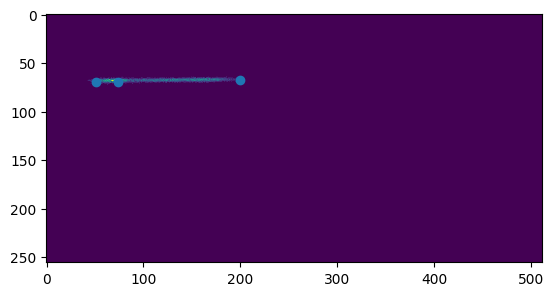

In [ ]:
for image, target in train_dataset.take(1):
  print(image.shape)
  print(target.shape)
  points = target.reshape(-1, 3, 2)
  plt.imshow(image[0, :, :])
  plt.scatter(points[0, :, 0], points[0, :, 1])